# Tutorial 2

In this tutorial we will go over the codes that will show you how to do basic seismological observations.  
We will do the following:  
- Downloading of event and waveform data
- Automatic phase picking
- Theoretical travel time calculation
- Earthquake location
- Response removal
- Magnitude calculation
- Matched filter detection

We will be using Obspy python library to do most of our work.  
For better understanding, reffer to its manual:  
[Obspy manual](http://docs.obspy.org/packages/index.html)
------

We start with the basic jupyter commands. This line will make sure, our plots are shown inside the notebook.

In [23]:
# make ploting inline of jupyter notebook
%matplotlib inline

------
Followed by the python import statements.  


In [24]:
# import necessary libraries
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime, read_inventory, Stream
from obspy.taup import TauPyModel, plot_travel_times
from obspy.geodetics.base import gps2dist_azimuth, kilometer2degrees
from obspy.signal.trigger import recursive_sta_lta, trigger_onset
from obspy.clients.fdsn import RoutingClient, Client
from obspy.signal.trigger import ar_pick
import cartopy
import numpy as np
import pprint
import os

------
After the import statements, normaly we define our functions if any

In [25]:
'''
This function is used for plotting of the seismograms. It is not needed, since the obspy already has
this functionality, but since we will be adding some elements to the plot, it makes it more convinient.
'''

def mpl_plot(stream, figsize=[12.0, 8.0], linewidth=1):
    if len(stream)==1:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        ax.plot(stream[0].times("matplotlib"), stream[0].data, "k-", linewidth=linewidth, label=stream[0].stats.station+'.'+stream[0].stats.channel)
        ax.legend(loc=2)
    else:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        for i, tr in zip(range(0,len(stream)), stream):
            ax[i].plot(tr.times("matplotlib"), tr.data, "k-", linewidth=linewidth, label=tr.stats.station+'.'+tr.stats.channel)
            ax[i].legend(loc=2)

------
### Earthquake catalog
First, lets download events data from the ISC webservice.  
[International Seismological Centre - ISC](http://isc-mirror.iris.washington.edu)

In [26]:
'''
Lets define the client. We will use ISC since the local observatory is sending all the event
data to ISC where we can get access to it. 
'''
client = Client("ISC")

# Define the start time and end time of the catalog
startday_cat = UTCDateTime(2019, 1, 1, 0, 0, 0)
endday_cat = UTCDateTime(2019, 2, 1, 0, 0, 0)

# Define the area of interest. Check obspy manual for other settings.
min_lat, max_lat = 45.35, 46.94
min_lon, max_lon = 13.28, 16.72

In [27]:
# Execute the get_events call to obtain predefined catalog
cat = client.get_events(startday_cat, 
                        endday_cat, 
                        minlongitude=min_lon, 
                        maxlongitude=max_lon, 
                        minlatitude=min_lat, 
                        maxlatitude=max_lat)

print(cat)

297 Event(s) in Catalog:
2019-01-01T00:44:07.000000Z | +45.934,  +16.103 | 0.8  ML
2019-01-01T05:24:26.700000Z | +45.701,  +14.209 | 0.9  ML
...
2019-01-31T23:44:54.400000Z | +45.650,  +14.263 | 0.4  ML
2019-01-31T23:47:52.700000Z | +45.648,  +14.253 | 0.2  ML
To see all events call 'print(CatalogObject.__str__(print_all=True))'


/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548046' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548065' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548073' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548144' does not have a magnitude and will not be plotted.
  warnings.warn(msg)


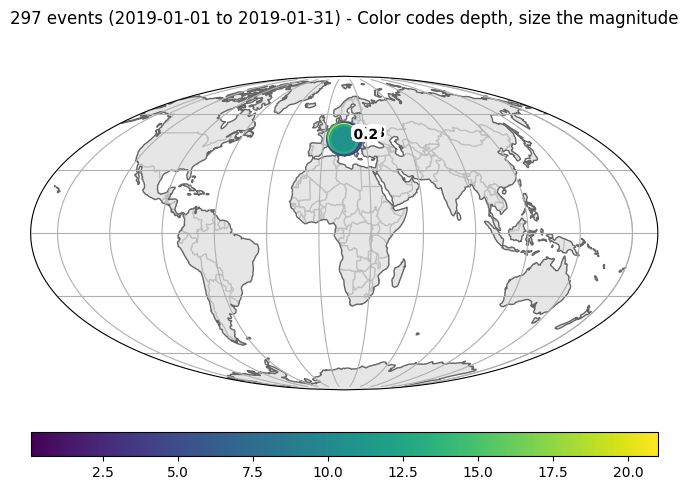

In [28]:
'''
in the code, that we would write in a script, you can do this simply by
cat.plot(method='cartopy'). We assign this to x, so the plot is not displayed twice.
This happens when you call plot and return plot from the function at the same time.
'''
x = cat.plot(method='cartopy')

/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548046' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548065' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548073' does not have a magnitude and will not be plotted.
  warnings.warn(msg)
/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/core/event/catalog.py:680: UserWarning: Event 'smi:ISC/evid=617548144' does not have a magnitude and will not be plotted.
  warnings.warn(msg)


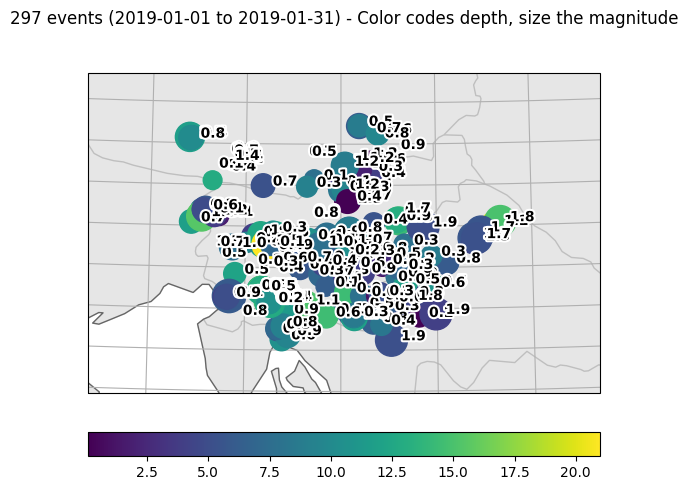

In [29]:
# Its there, but lets zoom on it
x = cat.plot('local', 'i', method='cartopy')

In [30]:
'''
There is many events that happened in the region during the specified time.
We need to filter the catalog since we dont have time to work with all.
Wait until your thesis :)
'''
selected_events = cat.filter("time > 2019-01-31T23:35:0", "time < 2019-01-31T23:40:0")
print(selected_events)

1 Event(s) in Catalog:
2019-01-31T23:38:08.800000Z | +45.644,  +14.259 | 1.4  ML


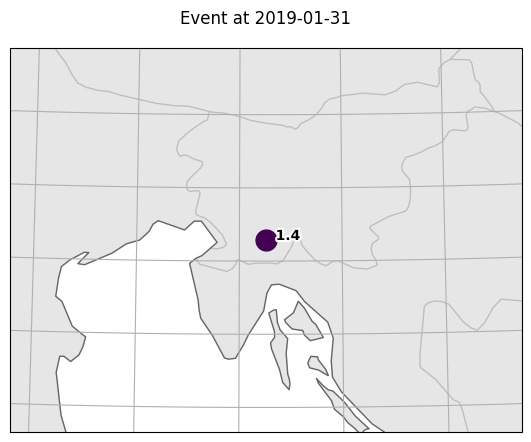

In [31]:
x = selected_events.plot('local', 'i', method='cartopy')

------
### Station inventory
We need to download the information about the stations in the region.  
You can get info about the seismological networks here:  
[Orfeus](http://orfeus-eu.org/data/eida/networks/)  
or  
[FDSN](https://www.fdsn.org/networks/?paginate=no)  
or others...

In [32]:
# We know that we are dealing with the seismic network of Slovenia. The network code is SL
net = 'SL'

# This time we will use a different provider (before it was ISC). Depands on the data we need.
client = Client("IRIS")

In [33]:
'''
Execute to download the data of Slovenian seismic network.
level='response' will get us the info needed for removal of instrumental response.
'''

sl_net = client.get_stations(network=net, 
                            station="*",
                            level='response')

print(sl_net)

Inventory created at 2023-05-26T11:20:23.092900Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?network=SL&station=%...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			SL
		Stations (25):
			SL.BOJS (Bojanci, SL)
			SL.CADS (Cadrg, SL)
			SL.CEY (Cerknica, SL)
			SL.CRES (Cresnjevec, SL)
			SL.CRNS (Crni vrh, SL)
			SL.DOBS (Dobrina, SL)
			SL.GBAS (Gornja Brezovica, SL)
			SL.GBRS (Gornja Briga, SL)
			SL.GCIS (Gornji Cirnik, SL)
			SL.GOLS (Golise, SL)
			SL.GORS (Gorjuse, SL)
			SL.GROS (Grobnik, SL)
			SL.JAVS (Javornik, SL)
			SL.KNDS (Knezji Dol, SL)
			SL.KOGS (Kog, SL)
			SL.LJU (Ljubljana, SL)
			SL.MOZS (Mozjanca, SL)
			SL.PDKS (Podkum, SL)
			SL.PERS (Pernice, SL)
			SL.ROBS (Robic, SL)
			SL.SKDS (Skadanscina, SL)
			SL.VISS (Visnje, SL)
			SL.VNDS (Vrh nad Dolskim, SL)
			SL.VOJS (Vojsko, SL)
			SL.ZALS (Zalesnik (v pomoznem jasku),SLtemp)
		Channels (1026):
			SL.BOJS..BHZ (3x),

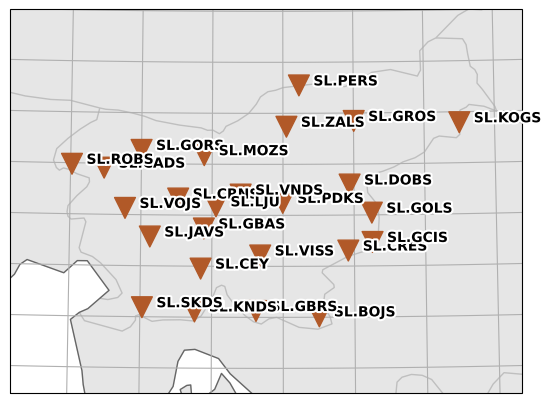

In [34]:
x = sl_net.plot('local', 'i', method='cartopy')

------
### Waveform data
Now, we will download the waveform data of few selected stations,  
that are located near the earthquake we are interested in. I know  
which stations these are.  

For European data we use Orfeus:  
[Orfeus](http://orfeus-eu.org/data/eida/networks/)  

In [35]:
# Defined stations
stations = ['CEY', 'GBAS', 'JAVS', 'KNDS', 'SKDS', 'VOJS']

In [36]:
# This is another version of client. For more, check Obspy manual.
rsClient = RoutingClient("eida-routing")

# Lets download only 5 minutes around the event.
startday_wfs = UTCDateTime(2019, 1, 31, 23, 35, 0)
endday_wfs = UTCDateTime(2019, 1, 31, 23, 40, 0)

In [37]:
# We generate an empty stream object into witch we will add our downloaded data.
selected_sta = Stream()

for sta in stations:
    st = rsClient.get_waveforms(network=net, station=sta, channel="HH*", starttime=startday_wfs, endtime=endday_wfs)
    st.merge(fill_value=0)
    st.detrend('simple')
    st.detrend('demean')
        
    for tr in st:
        selected_sta+=tr

print(selected_sta)

18 Trace(s) in Stream:
SL.CEY..HHE  | 2019-01-31T23:34:59.469536Z - 2019-01-31T23:40:01.979536Z | 200.0 Hz, 60503 samples
SL.CEY..HHN  | 2019-01-31T23:34:58.289538Z - 2019-01-31T23:40:01.679538Z | 200.0 Hz, 60679 samples
SL.CEY..HHZ  | 2019-01-31T23:34:59.964536Z - 2019-01-31T23:40:00.314536Z | 200.0 Hz, 60071 samples
SL.GBAS..HHE | 2019-01-31T23:34:57.714538Z - 2019-01-31T23:40:00.314538Z | 200.0 Hz, 60521 samples
SL.GBAS..HHN | 2019-01-31T23:34:59.929536Z - 2019-01-31T23:40:00.839536Z | 200.0 Hz, 60183 samples
SL.GBAS..HHZ | 2019-01-31T23:34:58.669536Z - 2019-01-31T23:40:02.424536Z | 200.0 Hz, 60752 samples
SL.JAVS..HHE | 2019-01-31T23:34:59.899538Z - 2019-01-31T23:40:01.394538Z | 200.0 Hz, 60300 samples
SL.JAVS..HHN | 2019-01-31T23:34:59.434538Z - 2019-01-31T23:40:01.199538Z | 200.0 Hz, 60354 samples
SL.JAVS..HHZ | 2019-01-31T23:34:59.949538Z - 2019-01-31T23:40:00.484538Z | 200.0 Hz, 60108 samples
SL.KNDS..HHE | 2019-01-31T23:34:58.814538Z - 2019-01-31T23:40:00.224538Z | 200.0 Hz, 6

In [38]:
# not needed, but usefull for offline use
output_fld = 'wfs_dl/'

if not os.path.exists(output_fld):
    os.makedirs(output_fld)

for tr in selected_sta:
    tr.write(output_fld+tr.stats.station+'_'+tr.stats.channel+'.'+'mseed', format='MSEED')

/Users/blaz/.pyenv/versions/3.9.7/envs/tides/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


------
### Automatic phase picking
In this part we will use one of the methods for automatic phase detection and picking.  
As you will see, classic automatic methods are good enough for initial knowladge on what is happening.  
If we want a clearer picture, phase picking must be done manualy.  

For manual phase picking I advise to use Snuffler from Pyrocko:  
[Pyrocko](https://pyrocko.org)  

Of course, this will take a lot of time. The latest and greatest for automatic picking  
which is also very precise, more or less like our own handpicking, comes from the Machine Learning  
comunities.  

Check more on that here:  
[PhaseNet](https://www.researchgate.net/publication/323655314_PhaseNet_A_Deep-Neural-Network-Based_Seismic_Arrival_Time_Picking_Method)

In [39]:
# We already have event origins in the event we selected before.
origin_time = selected_events[0].origins[0].time
event_lat, event_lon, event_z = selected_events[0].origins[0].latitude,\
                                selected_events[0].origins[0].longitude,\
                                selected_events[0].origins[0].depth/1000

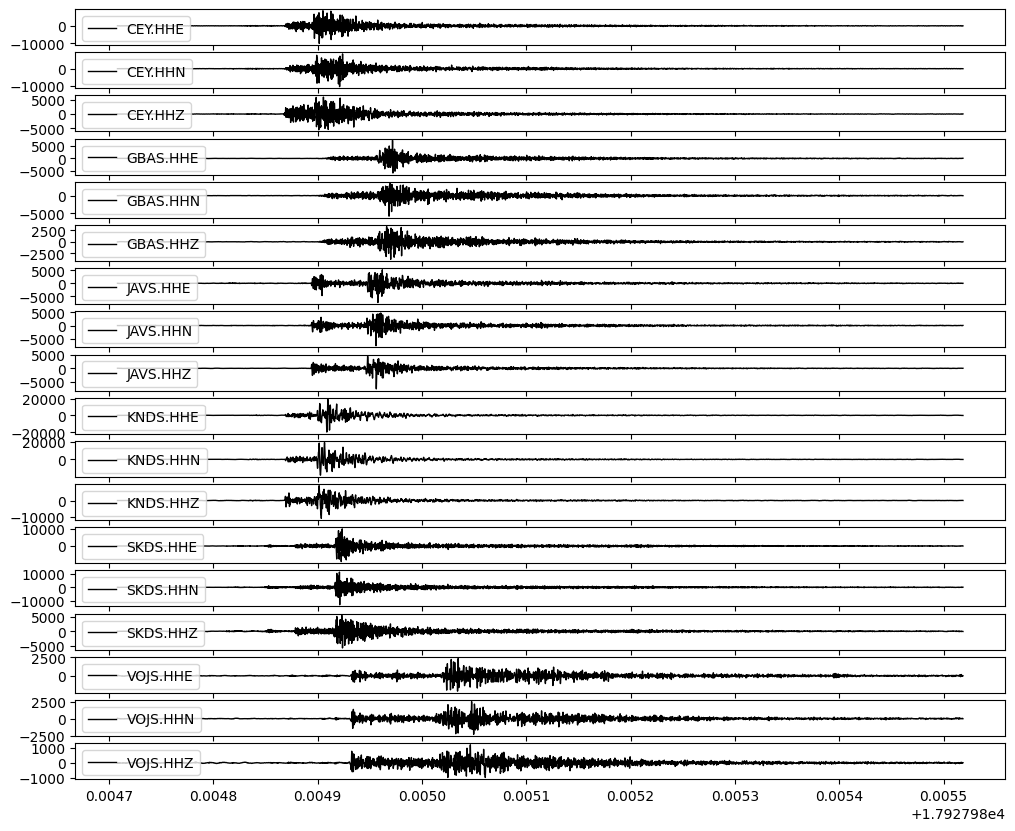

In [40]:
# read in the waveforms. If we stored them in the output folder use this, otherwise selected_sta
st = read(output_fld+'*')
st_event = st.copy()
st_event.filter('bandpass', freqmin=1.0, freqmax=30.0)
st_event.trim(origin_time-10, origin_time+60)
st_event.sort()
#st_event.plot()

mpl_plot(st_event, figsize=[12.0, 10.0], linewidth=1)

In [41]:
'''
Lets run the ar-picker. We will store the detected P and S phases in two different dictionaries
for later use.
'''
auto_detections_p = {}
auto_detections_s = {}

# Ar-picker function requires waveforms to be split on the channels. 
st_filtered = st_event.copy()
st_filtered_z = st_filtered.select(component='Z')
st_filtered_n = st_filtered.select(component='N')
st_filtered_e = st_filtered.select(component='E')

for tr_z, tr_n, tr_e in zip(st_filtered_z, st_filtered_n, st_filtered_e):
    df = tr.stats.sampling_rate
    p_pick, s_pick = ar_pick(tr_z.data, tr_n.data, tr_e.data, df,2.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
    auto_detections_p[tr_z.stats.station] = p_pick
    auto_detections_s[tr_z.stats.station] = s_pick

In [42]:
print('Detected P phases:\n')
pprint.pprint(auto_detections_p)
print('\nDetected S phases:\n')
pprint.pprint(auto_detections_s)

Detected P phases:

{'CEY': 13.864999771118164,
 'GBAS': 16.635000228881836,
 'JAVS': 16.045000076293945,
 'KNDS': 13.829999923706055,
 'SKDS': 14.65999984741211,
 'VOJS': 19.299999237060547}

Detected S phases:

{'CEY': 16.5049991607666,
 'GBAS': 22.579999923706055,
 'JAVS': 21.200000762939453,
 'KNDS': 16.514999389648438,
 'SKDS': 18.110000610351562,
 'VOJS': 27.81999969482422}


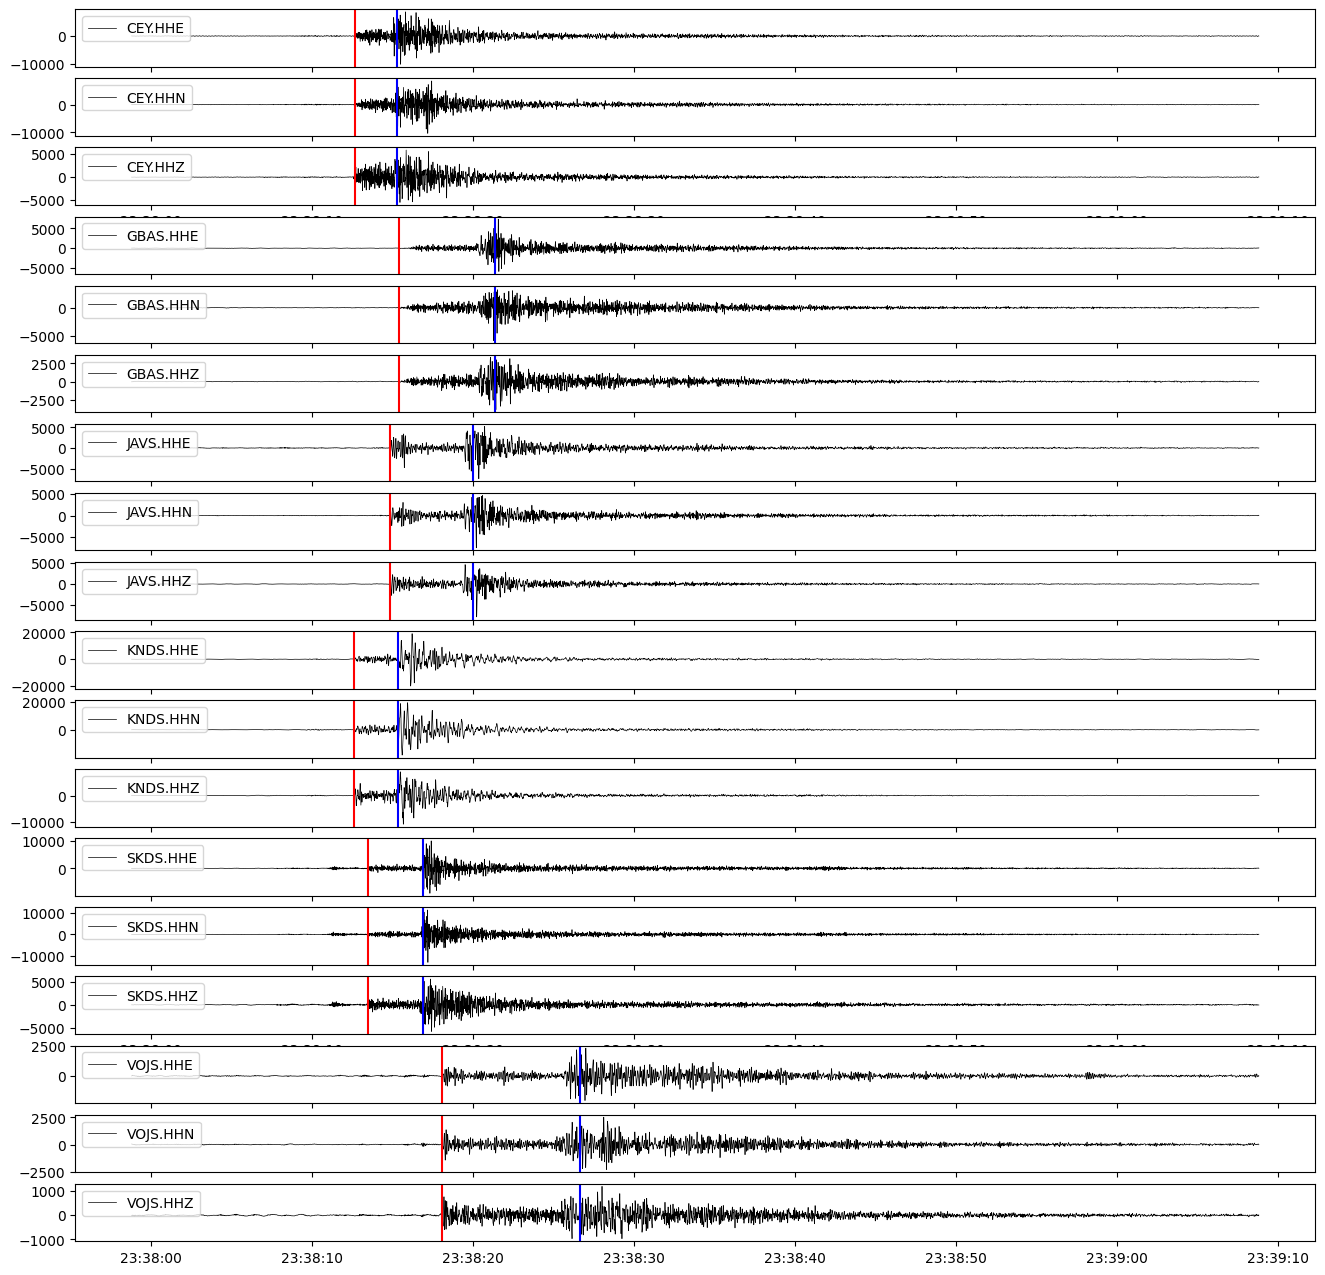

In [43]:
# Plot of the automatic picks
fig, ax = plt.subplots(nrows=len(st_filtered), ncols=1, figsize=[16.0, 16.0])
for i, tr in zip(range(0,len(st_filtered)), st_filtered):
    ax[i].plot(tr.times("matplotlib"), tr.data, "k-", linewidth=0.5, label=tr.stats.station+'.'+tr.stats.channel)
    ax[i].axvline((tr.stats.starttime+auto_detections_p[tr.stats.station]).datetime, c='r')
    ax[i].axvline((tr.stats.starttime+auto_detections_s[tr.stats.station]).datetime, c='b')
    ax[i].legend(loc=2)

------
### Theoretical phase travel time calculation
In this part we will calculate theoretical P and S phases for the same event.  
For this, we need to know:  
- predefined velocity structure of the earth (will use IASP91)
- location of the event
- depth of the event
- location of the stations

In [45]:
# This is a predefined model, we can easily import our own
model = TauPyModel(model="iasp91")

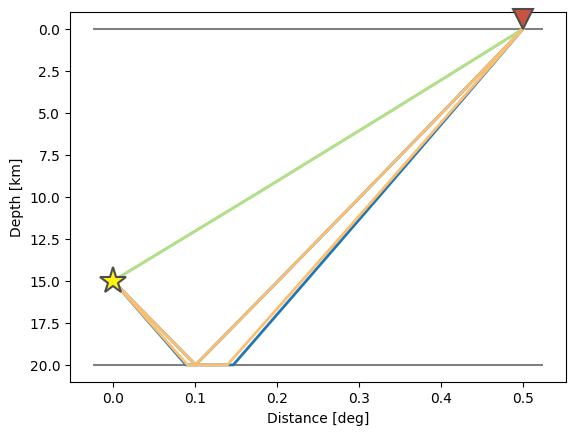

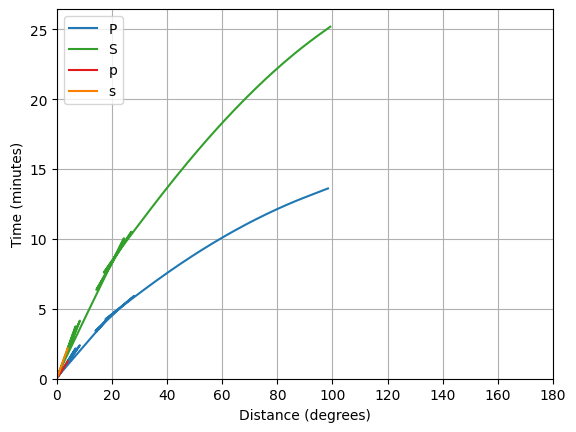

In [46]:
# Simple plot of P and S phases for an event at depth of 15km on a station cca 50km away

arrivals = model.get_ray_paths(source_depth_in_km=15,
                               distance_in_degree=0.5,
                               phase_list=['p', 'P', 's', 'S'])

x = arrivals.plot_rays(plot_type="cartesian")

y = plot_travel_times(source_depth=15, phase_list=['p', 'P', 's', 'S'], verbose=True)

In [47]:
# Lets calculate teoretic TT using IASP91
ttt_p = {}
ttt_s = {}

for net in sl_net:
    for sta in net:
        sta_lat, sta_lon = sta.latitude, sta.longitude
        dists = gps2dist_azimuth(sta_lat, sta_lon, event_lat, event_lon)
        dist_km = dists[0]/1000
        dist_deg = kilometer2degrees(dist_km)
        
        arrivals = model.get_travel_times(source_depth_in_km=event_z, distance_in_degree=dist_deg)
        for arrival in arrivals:
            if arrival.name == 'p':
                ttt_p[sta.code] = arrival.time
            elif arrival.name == 's':
                ttt_s[sta.code] = arrival.time
            else:
                pass

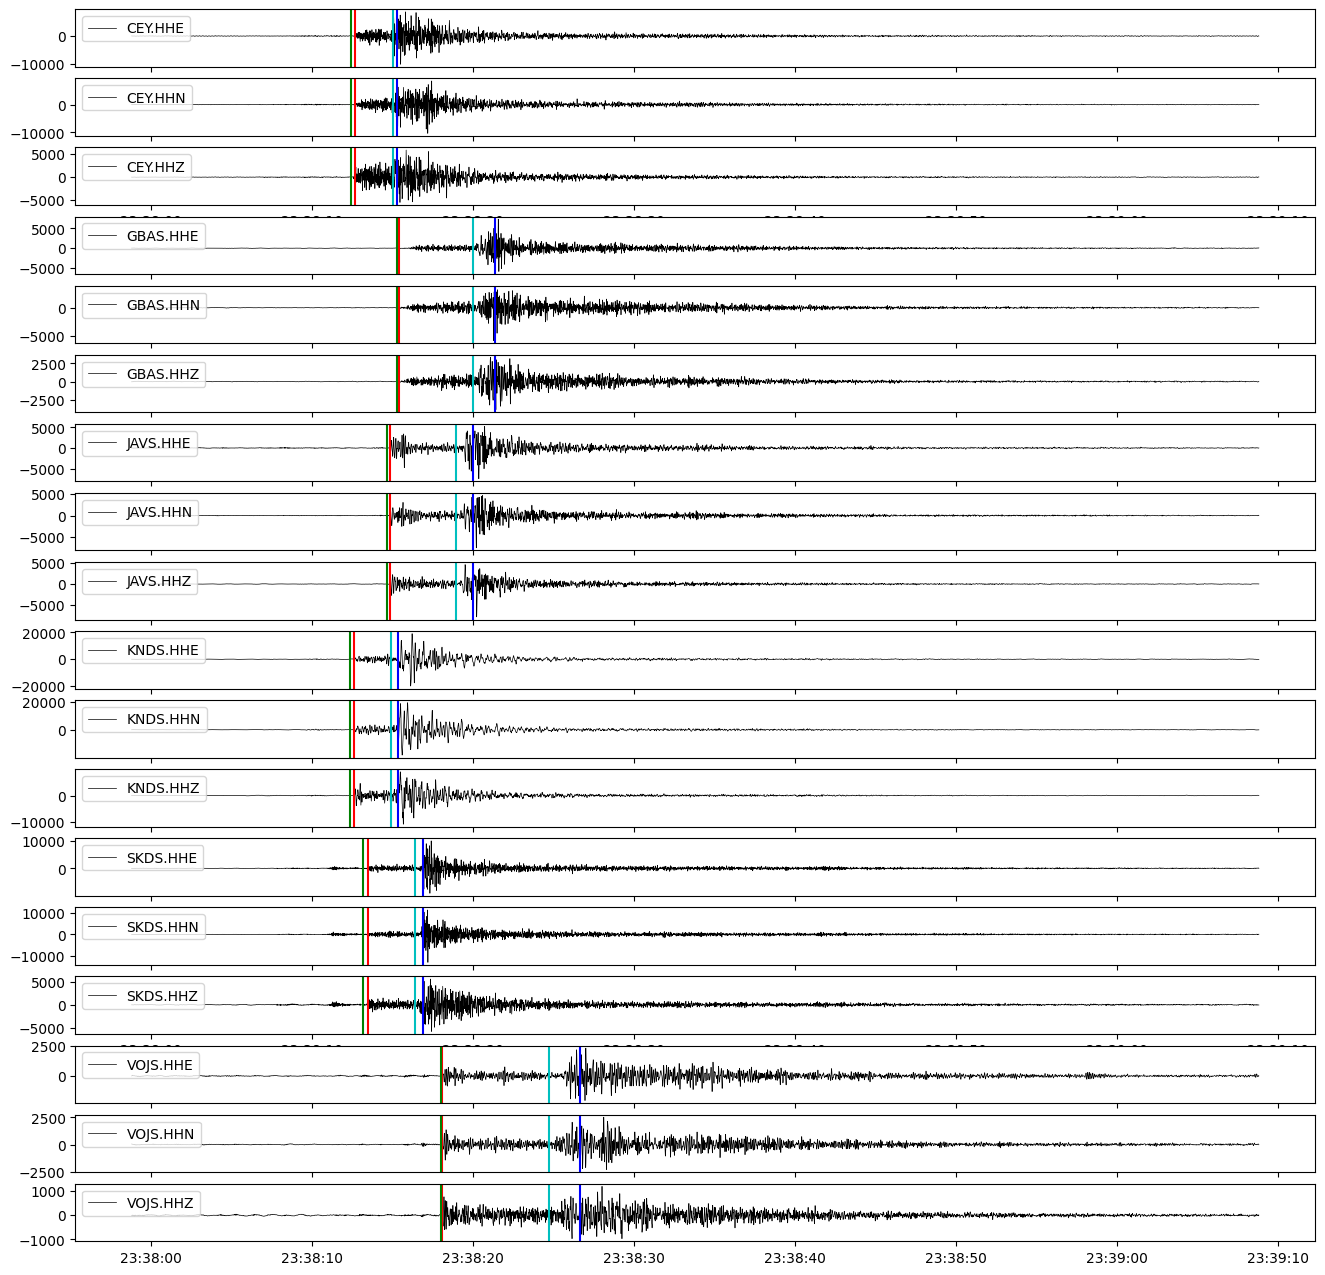

In [48]:
# Plot automatic detections and calculated travel times
fig, ax = plt.subplots(nrows=len(st_filtered), ncols=1, figsize=[16.0, 16.0])
for i, tr in zip(range(0,len(st_filtered)), st_filtered):
    ax[i].plot(tr.times("matplotlib"), tr.data, "k-", linewidth=0.5, label=tr.stats.station+'.'+tr.stats.channel)
    ax[i].axvline((tr.stats.starttime+auto_detections_p[tr.stats.station]).datetime, c='r')
    ax[i].axvline((tr.stats.starttime+auto_detections_s[tr.stats.station]).datetime, c='b')
    
    ax[i].axvline((origin_time+ttt_p[tr.stats.station]).datetime, c='g')
    ax[i].axvline((origin_time+ttt_s[tr.stats.station]).datetime, c='c')
    ax[i].legend(loc=2)

------
### Event calculation using automatic phase arrivals

For the event location we will use the automatic phase arrivals.  
We will use NonLinLoc software package, available here:  
[NonLinLoc](http://alomax.free.fr/nlloc/) 

Due to the complicated way of setting this up, I will only show you how this is done.  
Basically, we need 3 things:  
- travel time grid
- velocity model
- observed travel times

In [49]:
# Prepare NLL file observation file

stream_starttime = st_filtered[0].stats.starttime

with open('nll_phase_file', 'w') as phasefile:
    for sta, p_phase in auto_detections_p.items():
        pick_time = stream_starttime+p_phase
        pick_time_str = pick_time.strftime('%Y%m%d %H%M %S.%f')
        phasefile.write(f'{sta:4}   ?    Z    ? P      ? {pick_time_str}  GAU -1.00e+00 -1.00e+00 -1.00e+00 -1.00e+00\n')
    for sta, s_phase in auto_detections_s.items():
        pick_time = stream_starttime+s_phase
        pick_time_str = pick_time.strftime('%Y%m%d %H%M %S.%f')
        phasefile.write(f'{sta:4}   ?    N    ? S      ? {pick_time_str}  GAU -1.00e+00 -1.00e+00 -1.00e+00 -1.00e+00\n')   

------
### Event magnitude estimation.

In the last step, we will compute local magnitude of the selected event.  
To do so, we have to remove the response of each stations used and then measure the maximum amplitude on all 3 channels.  
After the removal of response, the waveform data will be in units of m (displacement).  
The formula need micrometers, so we have to trasfer to them.

We will use this formula to calculate the magnitude:  
ml = log10(max_ampl) + 2.5 * log10(epi_dist) - 1.2

In [50]:
st_mag = st.copy().filter('bandpass', freqmin=1, freqmax=20).trim(starttime = origin_time, endtime= origin_time+30)
st_mag.remove_response(inventory=sl_net, output='DISP')

18 Trace(s) in Stream:
SL.CEY..HHE  | 2019-01-31T23:38:08.799536Z - 2019-01-31T23:38:38.799536Z | 200.0 Hz, 6001 samples
SL.CEY..HHN  | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 samples
SL.CEY..HHZ  | 2019-01-31T23:38:08.799536Z - 2019-01-31T23:38:38.799536Z | 200.0 Hz, 6001 samples
SL.GBAS..HHE | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 samples
SL.GBAS..HHN | 2019-01-31T23:38:08.799536Z - 2019-01-31T23:38:38.799536Z | 200.0 Hz, 6001 samples
SL.GBAS..HHZ | 2019-01-31T23:38:08.799536Z - 2019-01-31T23:38:38.799536Z | 200.0 Hz, 6001 samples
SL.JAVS..HHE | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 samples
SL.JAVS..HHN | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 samples
SL.JAVS..HHZ | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 samples
SL.KNDS..HHE | 2019-01-31T23:38:08.799538Z - 2019-01-31T23:38:38.799538Z | 200.0 Hz, 6001 sampl

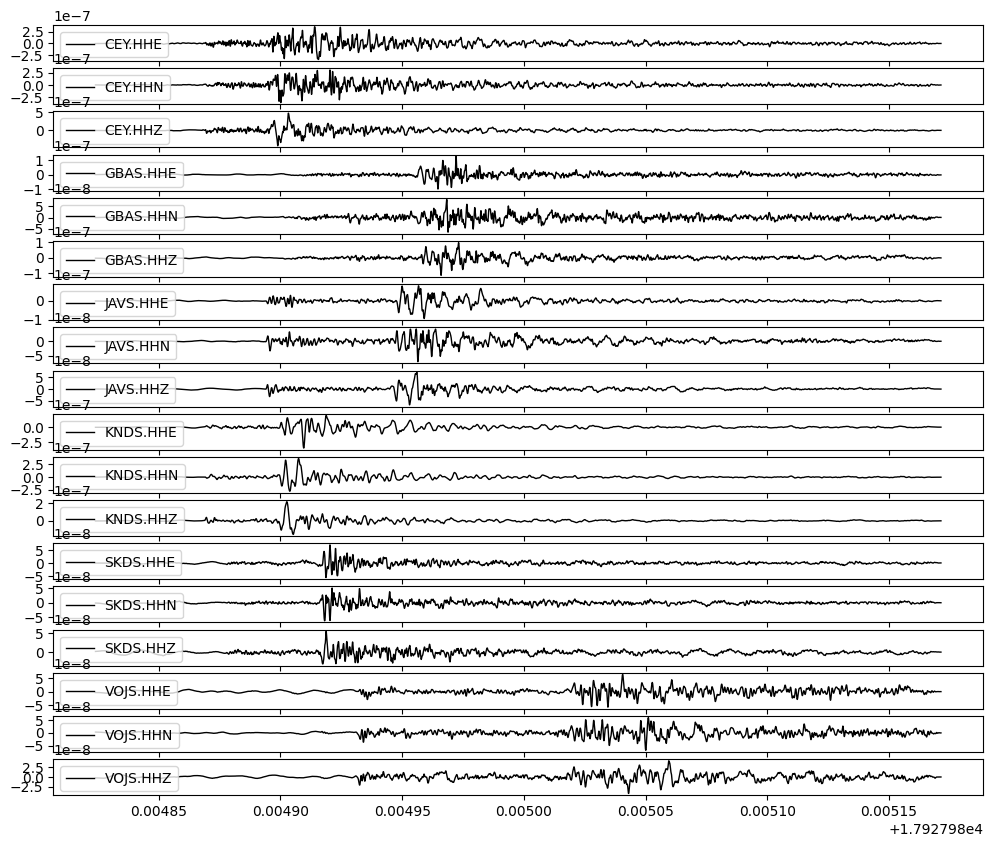

In [51]:
mpl_plot(st_mag, figsize=[12.0, 10.0], linewidth=1)

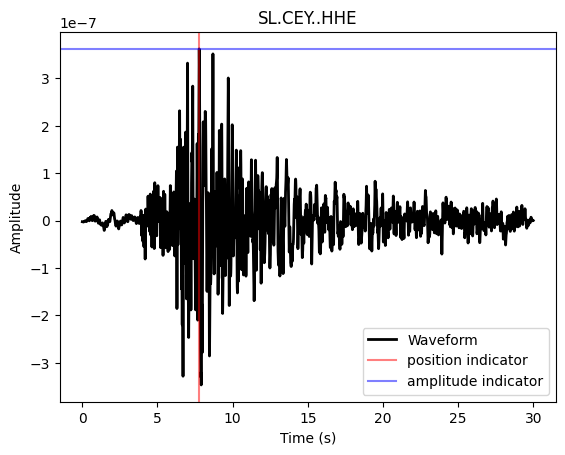

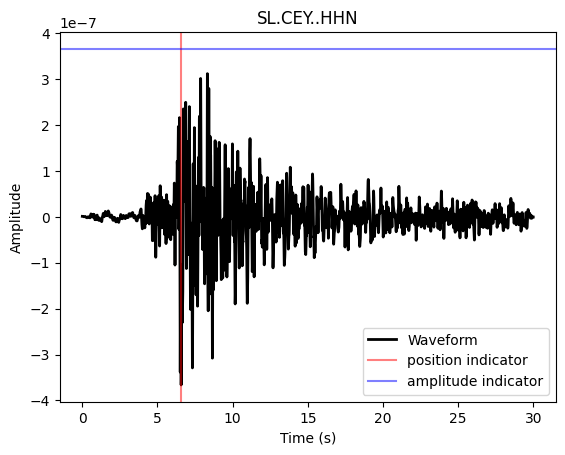

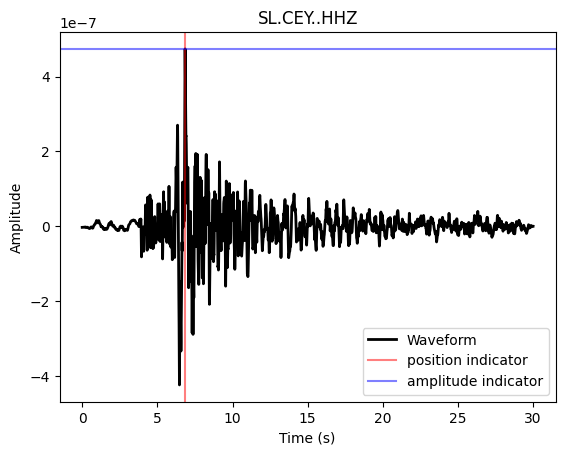

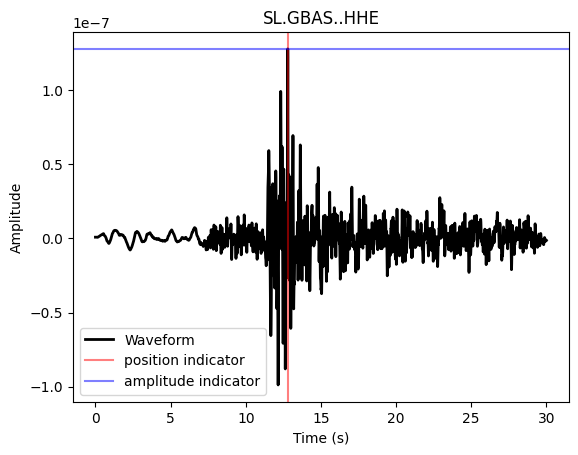

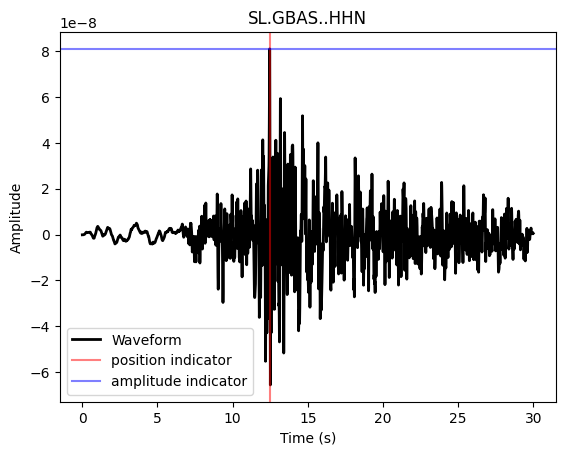

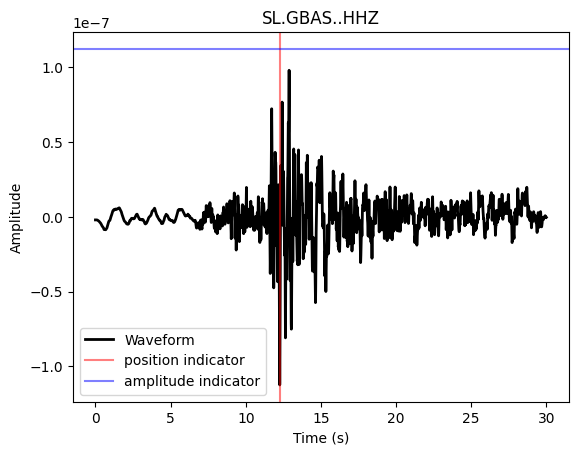

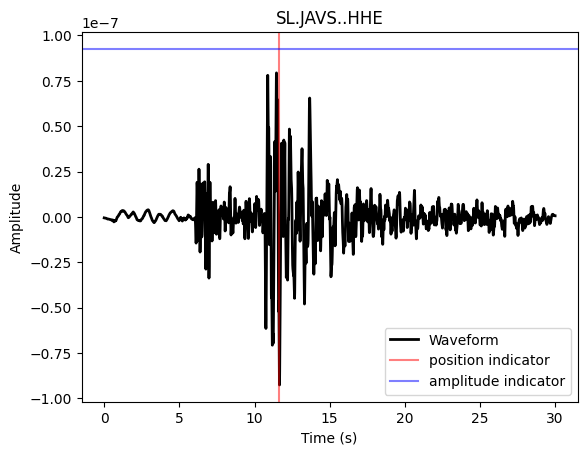

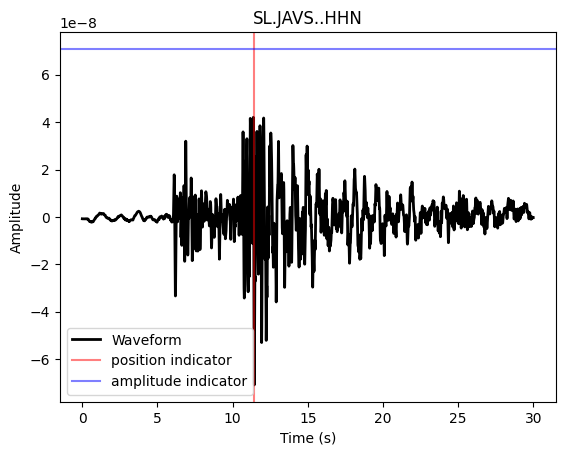

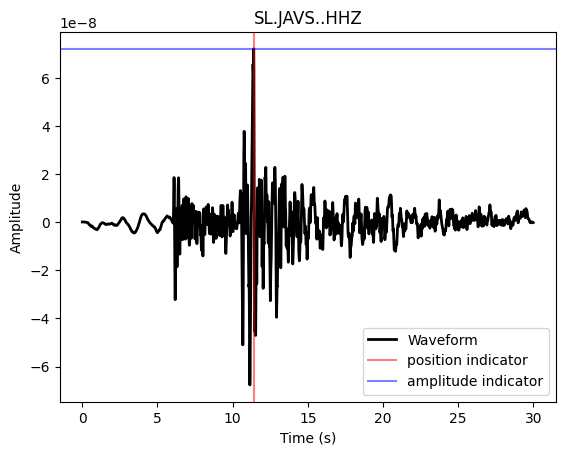

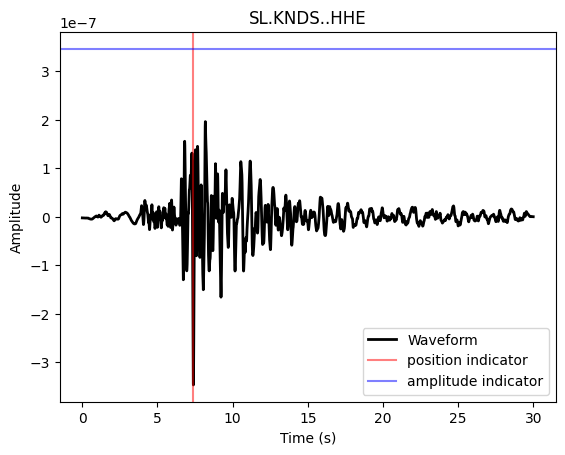

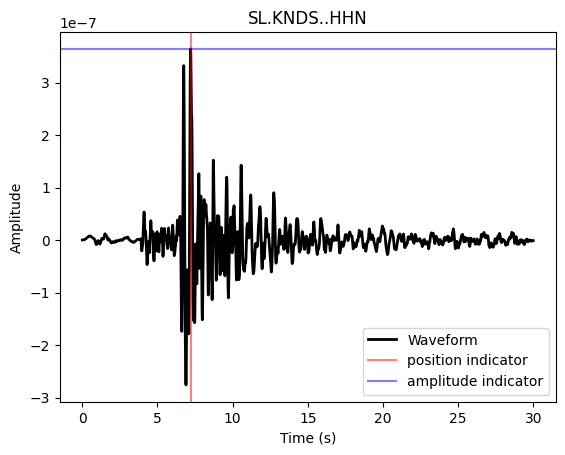

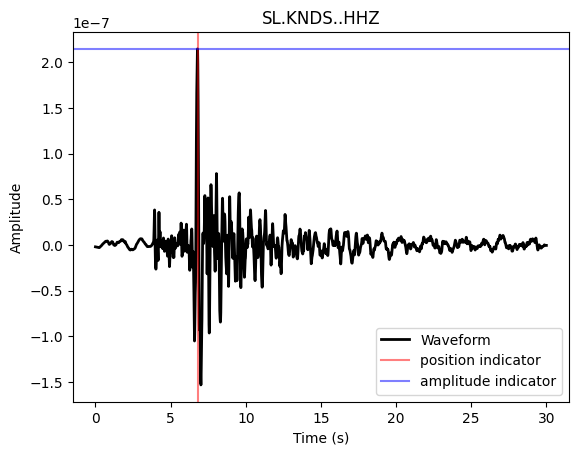

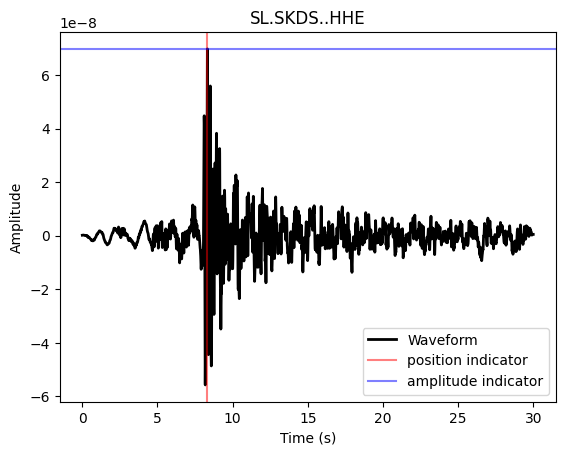

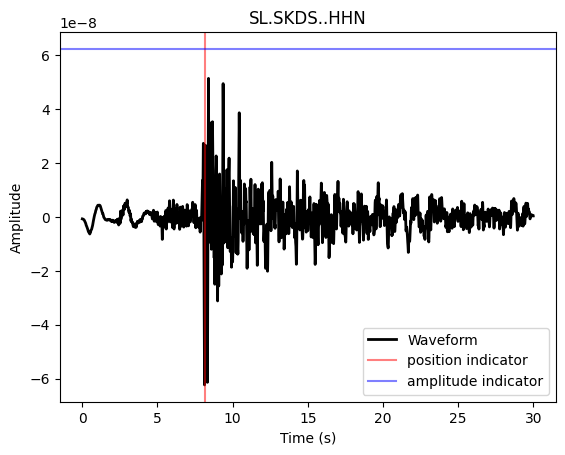

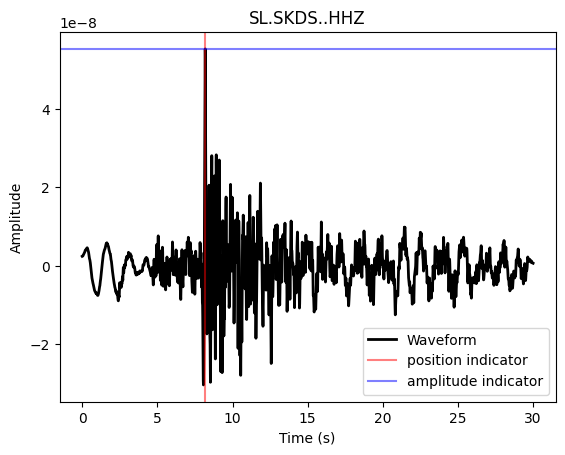

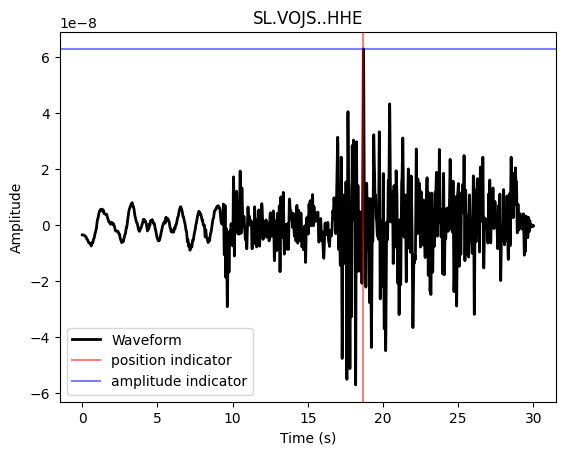

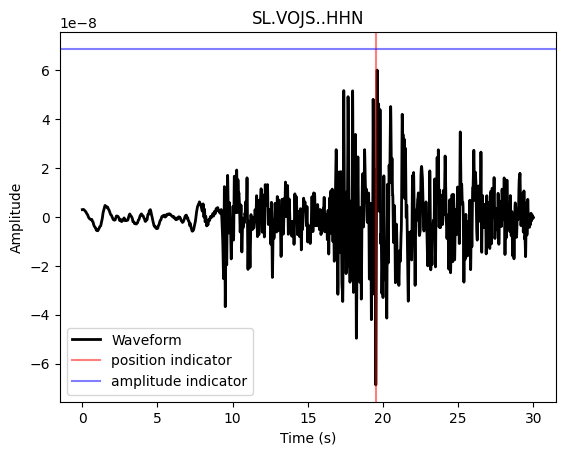

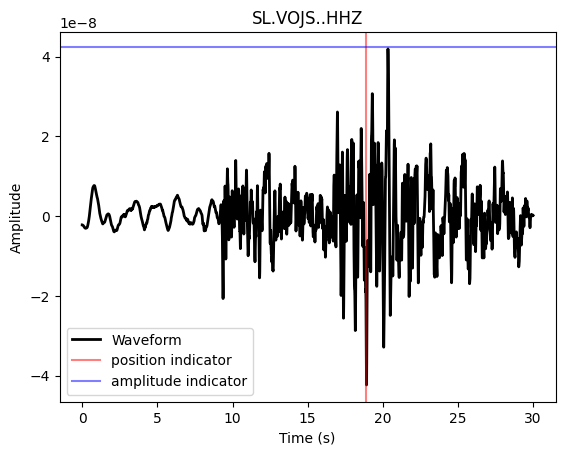

Local magnitude is: 2.131747473524393


In [52]:
# Lets define some functions

# This one finds maximum amplitude and its location in the trace
def max_pos_finder(tr):
    max_val = tr.max()
    max_pos = np.where(tr.data == max_val)    
    
    return np.abs(max_val), max_pos[0]

# Compute the local magnitude
def local_mag(max_val, epi_dist=29):
    val = max_val  * 1000000
    ml = np.log10(val) + 2.5 * np.log10(epi_dist) - 1.2
    return ml
 
mls = []
for tr in st_mag:
    max_val, max_pos= max_pos_finder(tr)
    mls.append(local_mag(max_val))
    
    plt.plot(tr.times(), tr.data,color='k', linewidth=2, label='Waveform')
    plt.axvline(x=max_pos*tr.stats.delta, color='r', alpha=0.5, label='position indicator')
    plt.axhline(y=max_val, color='b',alpha=0.5, label='amplitude indicator')
    plt.title(tr.id)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='best')
    plt.show()
    
print('Local magnitude is:', max(mls))